# Import packages 
#### needed for coordinates retrieve (lineage tree) maths (numpy) and interactive plotting (matplotlib)

In [1]:
import os
from TGMMlibraries import lineageTree
import numpy as np
#abreviation of functions numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook
#matplotlib is a function that allow us to plot interactive graphs as we write the code, even in 3D

import seaborn as sns
import pandas as pd

class ColorMap(object):
    def __init__(self, values, cmap='jet', default='w'):
        values = sorted(values)
        if None in values: values.remove(None)        
        if all([isinstance(i, int) for i in values]):
            self.values = range(values[0], values[-1]+1)
            self.cmap = plt.cm.get_cmap(cmap, len(self.values))
        elif all([isinstance(i, float) for i in values]):
            
            self.values = None   
            self.cmap = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=values[0], vmax=values[-1]), cmap=cmap)
        else:
            self.values = values
            self.cmap = plt.cm.get_cmap(cmap, len(self.values))
        self.default = default

    def __call__(self, value):
        if value is None:
            return self.default
        elif self.values is None:
            return self.cmap.cmap(self.cmap.norm(value))
        else:
            if not value in self.values:
                raise ValueError('`value` parameter')
        return self.cmap(self.values.index(value))

We define lT as the execution of LineageTree over the xml file path. This is the only manual step in this python script (Although we could also create a dialog to get the path). Remember to change \ by \\\ if you are in windows.

In [64]:
## Path to data
tracking_file = 'S:\\LAB_MT\\RESULTADOS\\MiQuel\\Paper Endocardio\\data\\live_imaging\\tracking\\KM_18-05-07_TimeRegistration-mamut_extended_curated.xml'

## Path to save the figures
out = './figures_definitive'


In [65]:
# load .xml mamut tracking file with Lineage Tree libary
lT = lineageTree(tracking_file, MaMuT = True)

# Create a sorted ids_time dictionary
With this structure:
{ID : time }

In [66]:
node_time = {}

for time, cid in lT.time_nodes.items():
    for item in cid:
        node_time[item] = time

### Find the spots in the first time point and start from those and create a dictionary with their names
With this structure:
{'track name' : ID }

In [67]:
start_ids = lT.time_nodes[0] #this list has some nodes that don't belong to a track. then they will give error when we try lT.track_name(id)
#We get rid of them by adding to a new clean list, only the start nodes that belong to a track


start_nodes = []
for cid in start_ids:
    try:
        lT.track_name[cid] 
        start_nodes.append(cid)
    except:
        pass

In [68]:
start_tracks = dict((lT.track_name[k], k) for k in start_nodes)

### Download a text file with the start positions and track names so you can plot them on imaris t= 0

To do the image segmentations, I had to cut the raw data 
- x-range=1676,2608 
- y-range=1480,2670 
- z-range=395x5,540x5 
(z values are in pixels = 1, but for the actual representation in imaris 1 z pixel equals 5 to conserve the aspect ratio)

That is why now we need to reset the starting coordinates to the new origin before saving it in the points txt file.
Example:

In [69]:
lT.pos[81541]-[1676, 1480, 395*5]

array([161.55094731, 698.90018899, 253.37194743])

In [70]:
start_tracks

{'full_ec2': 81541,
 'partial_ExM_et4': 89157,
 'full_uc1': 72516,
 'full_ec_uc1': 59751,
 'partial_ExM_et': 90310,
 'full_my1': 69961,
 'full_my_SplMes1_finished': 62188,
 'full_ec_uc2': 87247,
 'full_my_JCF1': 58672,
 'full_ec4': 77489,
 'full_ec3': 76403,
 'full_my4': 78419,
 'full_et_aorta_noEtMes1': 78738,
 'Track_0': 50872,
 'full_ec1_finished': 50873,
 'Track_4': 76378,
 'full_ec_aorta1': 82202,
 'full_ExM_et_2': 88190}

In [71]:
filename = "KM1_CMandET_points_coordinates_pixels_new_origin.txt"

# Open the file for writing
with open(filename, "w") as file:
    for name, c_id in start_tracks.items():
        # Convert the point to a formatted string that imageJ 3D viewer can read
        coordinates = lT.pos[c_id]-[1676, 1480, 395*5]
        point_str = f'{name}: {coordinates.tolist()}' 

        # Write the formatted string to the file
        file.write(point_str)

        # Add a newline character to separate points
        file.write("\n")

print(f"Points saved to {filename}")

Points saved to KM1_CMandET_points_coordinates_pixels_new_origin.txt


### Obtain all cycles from that track name, which correspond to a single progenitor
We create a dictionary which key is the name of the track obtain fro the progenitors at the first time point and a list of lists as the value, where each list is a cycle from that progenitor

In [72]:
track_cycles = {} #this is the dictionary where we put all the cycles from all the progenitors, sorted by track name.
for name, c_id in start_tracks.items(): #this are all the initial ids, ids at time 0
    track_cycles[name] = [lT.get_cycle(c_id)]    # add a list of the initial cycles to the dictionary value. This will create a list of lists
    for cycle in track_cycles[name]: # for every cycle performs this operation to find the following branches
        try:
            for suc in lT.successor[cycle[-1]]: # here it will find the cycle for each of the two successors that the last id of the cycle must contain
                track_cycles[name].append(lT.get_cycle(suc))
            
        except:
            pass  #there is gonna be a point where we do not have more progenitors, more branches. In that case an error will appear (most recent call last, traceback) it passes.
        
    #the peculiarity of this loop is that, as it runs, the list cycles increases, and thus it performs the operation over the 
    #new cycles that incorporate, but it will not repeat it again with the initial cycles.

In [73]:
for name, cycles in track_cycles.items(): #modify every value of the dictionary
    track_cycles[name] = track_cycles[name][::-1] #invert the value of every key. Which means invert the list of cycles of every track

#### Calculate the length of each track
To obtain an estimate of the cell division time in the embryo

In [74]:
track_length = {}
for name, all_cells_track in track_cycles.items():
    track_length[name] = []
    for cell in all_cells_track:
        if (lT.time[cell[0]] != 0) & (lT.time[cell[-1]] != 355) : # discard firsts and lasts cells which cell cycle can be incomplete in the video
            track_length[name].append(len(cell)*5) # 4minutes time frame in case of KM1 video

track_length_KM1 = track_length

### Bind all the cycles to its progenitor. 
Every final cell in the video will have a track with all its progenitors. That means the branches corresponding to the progenitor cell will be more represented in the dictionary. 
The strategy we use to generate this list of lists is to follow back the final daughters. 
this way we obtain a track for every final daughter inside the value of the dictionary, as a list. 

In [75]:
def find_story(cell):
    for mother in c_cycles:
        try:
            if [mother[-1]] == lT.predecessor[cell[0]]:
                return find_story(mother + cell)

        except KeyError:
            tracks_cells[name].append(cell) #append the final result
            break

In [76]:
tracks_cells = {} #definitive dictionary with all the complete cycles for first progenitor to last daughter
for name, c_cycles in track_cycles.items(): #iterating over the track names, so it does it for all tracks.
    tracks_cells[name] = [] #creat an empty list in the dictionary value, so it has somewhere to append on, in the first iteration.
    for daughter in c_cycles: #starts from the end to check one by one the cycles 
        try:
            lT.successor[daughter[-1]] #if this cell has no children then it gives Keyerror and jump to except
            break #when a cell has children we dont want to find their story
            
            
        except KeyError:
            find_story(daughter)

### An excel for Dani bioinformatics
So he can do the behavior analysis tSNE, clustering of cell states etc

In [77]:
# Create a base 
df = pd.DataFrame(lT.track_name.items(),
                  columns = ['node_id', 'track_name'])

### Correcting coordinates to make them ok. In this email I explain why

Efectivamente, las “View registration” en el archivo “KM_18-05-07_TimeRegistration.xml” eran erróneas. He hecho todo el tracking con medidas incorrectas, sobredimensionadas.
 
Empezando en Linea 62:
 
<ViewRegistrations>
    <ViewRegistration timepoint="0" setup="0">
      <ViewTransform type="affine">
        <affine>1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 5.002462949142482 0.0</affine>
 
Los valores 1.0 1.0 5.002462949142482 para la matriz son incorrectos. Los he sustituido por el valor de pixel real:
 
<ViewRegistration timepoint="0" setup="0">
      <ViewTransform type="affine">
        <affine>0.4059999883174896 0.0 0.0 0.0 0.0 0.4059999883174896 0.0 0.0 0.0 0.0 2.0309998989105225 0.0</affine>
 
 
Y ahora, en el Big Data Viewer, los valores incrementan 0.406 en cada plano X o Y y  2.031 en Z cuando mueves la ruedecilla del ratón. La visualización ya corresponde a las medidas correctas del pixel.
 
He corregido el Excel de los tracks multiplicando X e Y por 0.4059… y Z por (2.030…/5.002…).
Ahora las coordenadas de los tracks deberían corresponder con su valor real en micras. Del cual se puede obtener el valor en pixels dividiéndolos entre 0.406 um in X, 0.406 um in Y, and 2.031 Z.


In [78]:
XYZ_coord = np.array([lT.pos[node_id] for node_id in lT.track_name.keys()])

df['X'] = XYZ_coord[:,0]*0.4059999883174896
df['Y'] = XYZ_coord[:,1]*0.4059999883174896
df['Z'] = XYZ_coord[:,2]*2.0309998989105225/5.002462949142482

In [79]:
endothelial = ['mixed_ET', 'et', 'ec3', 'etaorta1', 'ec_et_mes', 'ec2', 'ec']

In [80]:
def change_track_name(name):
    '''
    Returns "ET" if the input string contains "ec", "et", "aorta", or "uc" 
    (case-insensitive). Otherwise, returns "CM".
    
    Parameters:
    name (str): Input string to check for keyword matches.
    
    Returns:
    str: "ET" if keyword matches are found, "CM" otherwise.
    '''
    
    # Convert input string to lowercase for case-insensitive matching
    name_lower = name.lower()
    
    # Check if any of the keywords are in the input string
    if any(keyword in name_lower for keyword in ["ec", "et", "aorta", "uc"]):
        new_name = "ET"
    else:
        new_name = "CM"
        
    return new_name

In [82]:
def change_track_name_detailed(name):
    '''
    Returns "Endocardium" if the input string contains "ec"
    Returns "Embryonic endothelium" if the input string contains "et_aorta6", "uc2" or "uc3"
    Returns "Undifferentiated mesoderm" if the input string contains "partial_JCF1 or "mes"
    
    Parameters:
    name (str): Input string to check for keyword matches.
    
    Returns:
    str:
    '''
    
    # Convert input string to lowercase for case-insensitive matching
    name_lower = name.lower()
    
    # Check if any of the keywords are in the input string
    if any(keyword in name_lower for keyword in ["ec", "et", "aorta", "uc"]):
        new_name = "EC_alone_or_with_EmE-EmEt"
        
    if any(keyword in name_lower for keyword in ["full_et_aorta_noetmes1", "partial_et_aorta", "partial_uc2", "partial_uc3"]):
        new_name = "EmET_noEC"
        
    elif name_lower in ["partial_jcf1", "mes"]:
        new_name = "EmE_without_ET_nor_CM"

    else:
        new_name = "CM_alone_or_with_EmE"
        
    return new_name

In [83]:
df['cell_type'] = df['track_name'].apply(change_track_name) 

# Detailed
df['cell_type_detailed'] = df['track_name'].apply(change_track_name_detailed) 


In [84]:
timepoints = np.array([node_time[node_id] for node_id in lT.track_name.keys()])

df['timepoint'] = timepoints

## If I do not write the if condition, there are some nodes that are not present in the dict
## becase because they have no successors
successors = np.array([lT.successor[node_id] if node_id in lT.successor.keys() else '' for node_id in lT.track_name.keys()])

df['successors'] = successors

predecessors = np.array([lT.predecessor[node_id] if node_id in lT.predecessor.keys() else '' for node_id in lT.track_name.keys()])

df['predecessors'] = predecessors

In [85]:
## Save to excel file
df.sort_values(by = ['track_name','timepoint']).to_excel('KM1_tracking.xlsx', index = False)

# Graphical representation of the track coordinates in trajectories

First, we want to smooth the tracks so the artifacts of tracking are reduced. Thought, when calculating the straightness of the path, we need to be careful not to smooth too much.

Also we transform pixels to microns
0.406 um in X, 0.406 um in Y, and 2.031 Z

In [12]:
import random
from scipy import ndimage as nd

In [13]:
sigma = 1
name_Spos = {} #dictionary with the name of the track as the key, and the XYZ coordinates of all the cells in that track

for name, track in tracks_cells.items():
    name_Spos[name] = [] #create an empty list in value in order to have somewhere to append the XYZ arrays' list of each cell
    for cell in track:
        pos = np.array([lT.pos[c_id] for c_id in cell]) #global array of coordinates for that cell over time
        X_smooth = nd.filters.gaussian_filter1d(pos[:, 0], sigma=sigma, mode='nearest') * 0.406  #select all the arrays rows only column 0
        Y_smooth = nd.filters.gaussian_filter1d(pos[:, 1], sigma=sigma, mode='nearest') * 0.406  # transform units to microns
        Z_smooth = nd.filters.gaussian_filter1d(pos[:, 2], sigma=sigma, mode='nearest') * 2.031 
        Spos = np.column_stack((X_smooth, Y_smooth, Z_smooth))
        name_Spos[name].append(Spos)
        

*name_Spos* is the dictionary which contains {'name of the track':[[XYZ array cell 1],[XYZ array cell 2],...]} smoothed positions. Were each column of the array is X, Y or Z respectively

In [14]:
from matplotlib import colors as mcolors
colors = list(mcolors.XKCD_COLORS)

In [15]:
# del name_Spos['my4']

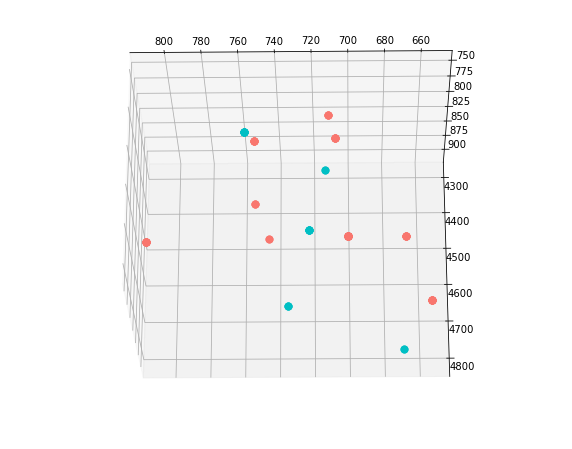

In [16]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111, projection = '3d')
cmap = ColorMap([11., 64.], 'plasma')
#colors = ['#8ffe09','r','#0033ff','#003311','#993333','#21c36f','#c46210','#ed3cca','#ffbf00','g','#000000','#8ffe09','r','#0033ff','#003311','#993333','#21c36f','#c46210','#ed3cca','#ffbf00','g','#000000']
a = -1 

endothelial = ['mixed_ET', 'et', 'ec3', 'etaorta1', 'ec_et_mes', 'ec2', 'ec']


for name, track in name_Spos.items():
    
    #print (name)
    
    for cell in track:
        colorball = '#00bfc4' if name in endothelial else '#f9766e'
        #ax.plot(cell[:,0], cell[:,1], cell[:,2], colorball, linewidth = 0.5) #X, Y, Z coordinates in the same array, in different columns
        ax.plot([cell[0,0]], [cell[0,1]], [cell[0,2]], colorball, marker='o', markersize = 7) #This ones have to go bewteen brackets because the program has to calculate the lenght of the list. As it has only 1 element, we need to make a list so it has a lenght even so.
        #ax.set_xlabel('Position in X', size = 20)
        #ax.set_ylabel('Position in Y', size = 20)
        #ax.set_zlabel('Position in Z', size = 20)
    
# Hide axis ticks and labels
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)


# finally plot the reference primitive streak point
# for name, pos in ref_PS.items():
#     colorball = 'y' if 'prox' in name else 'k' 
#     ax.plot([pos[0]], [pos[1]], [pos[2]], colorball+'*', markersize = 19, label = name)
#     ax.legend()
    
ax.view_init(155, 89)

path = os.path.join(out, 'tracks_embryo1_janelia' + '.svg')
plt.savefig(path, dpi = 300)


## Distribution of ET and non ET progenitors along Proximo-distal axis of the primitive streak

For that we created two spots manually in Mamut at time 0. One at the proximal-most side of the primitive streak, another at the distal margin. With this two points we have a proximodistal line that we can use as a rule for the proximo-distal distribution of the progenitors.

For each track, we will calculate the closest point to that line at time 0.

In [18]:
# We take the reference ids I clicked on the Primitive streak

ref_ids = []
for node_id, name in lT.node_name.items():
    if 'PS' in name:
        ref_ids.append(node_id)


# collect their names
ref_names = [lT.node_name[node_id] for node_id in ref_ids]

# and their coordinates, to plot later with the rest of the tracks
ref_pos = np.array([lT.pos[node_id] for node_id in ref_ids])

# normalize to microns 
ref_pos = ref_pos * [0.406, 0.406, 2.031]

#create a dictionary with their names and positions
ref_PS = dict(zip(ref_names, ref_pos))

# print to visualize
ref_PS


{'PS_proximal\n': array([ 837.79353506,  951.86648584, 4373.74847145]),
 'PS_middle\n': array([ 753.77368404,  900.77990886, 4430.38928352]),
 'PS_distal': array([ 634.57600056,  786.45004434, 4742.02177127])}

Next we plot the distribution of the plots, just to visualize the data

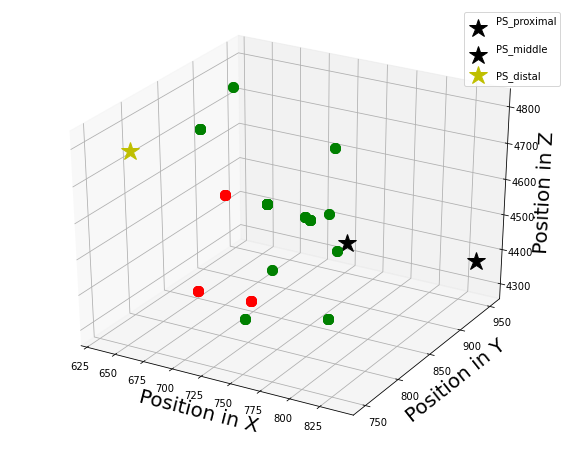

In [19]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111, projection = '3d')

# plot the reference primitive streak point
for name, pos in ref_PS.items():
    colorball = 'y' if 'dist' in name else 'k' 
    ax.plot([pos[0]], [pos[1]], [pos[2]], colorball+'*', markersize = 19, label = name)
    ax.legend()
    
# plot the initial points of each track

for name, track in name_Spos.items():
    
    for cell in track:
        colorball = 'g' if 'e' in name else 'r'  #green if endothelial else red

        ax.plot([cell[0,0]], [cell[0,1]], [cell[0,2]], colorball+'o', markersize = 10) #This ones have to go bewteen brackets because the program has to calculate the lenght of the list. As it has only 1 element, we need to make a list so it has a lenght even so.
        ax.set_xlabel('Position in X', size = 20)
        ax.set_ylabel('Position in Y', size = 20)
        ax.set_zlabel('Position in Z', size = 20)
    
    

### Save two .points separate text files with the initial coordinates for Endothelial and non-endothelial progenitors
This way we can plot it along with the raw data on ImageJ 3d viewer, that way we do not depend on Imaris or Matlab code from Kate Mcdole
For KM1, we will need to downsample the t1 image by 4x, so the .points coordinates have to be adapted too (matrix divided by 4)

## In order to find the closest point (p) from x0 (Time 0 of the track) to a segment formed by points x1 (proximalmost point of the PS) and x2 (distalmost point of the PS), we follow these steps:

1. Take the equation of the line
p = x1 + t (x2-x1)

2. The closest point p is such that the vector x0 - p is orthogonal to the line. (Pythagoras)
. is the dot product. The dot product of two orthogonal vectors is 0
(p - x0) . (x2 - x1) = 0

Knowing this we have the following function that calculates the closest point *p* and the distance *d* using this code
https://www.fundza.com/vectors/point2line/index.html

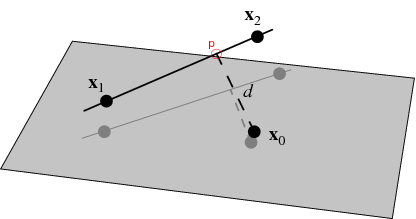

Now apply this function for every track's start position

In [20]:
PS_proximal, PS_distal = ref_pos[0], ref_pos[2]

In [21]:
from mathutils.geometry import intersect_point_line

line= PS_proximal, PS_distal

for name, c_id in start_tracks.items():
    start_pos = lT.pos[c_id] * [0.406, 0.406, 2.031]
    intersect = intersect_point_line(start_pos, PS_proximal, PS_distal)

    print(name, 'point is closest to',np.array(intersect[0]),'on the line')

ec_9 point is closest to [ 752.47052002  882.41467285 4528.37207031] on the line
uc point is closest to [ 759.19885254  887.89147949 4516.17871094] on the line
mixed_ET point is closest to [ 845.82336426  958.40270996 4359.19677734] on the line
et point is closest to [ 700.94543457  840.47399902 4621.74609375] on the line
my2 point is closest to [ 724.01904297  859.25561523 4579.93212891] on the line
CM_mes point is closest to [ 652.17108154  800.77227783 4710.13574219] on the line
ec_10 point is closest to [ 822.25164795  939.21563721 4401.91357422] on the line
my3 point is closest to [ 751.76086426  881.83703613 4529.65820312] on the line
ec3 point is closest to [ 623.13977051  777.14117432 4762.74658203] on the line
ec_8 point is closest to [ 790.5098877   913.37823486 4459.43652344] on the line
my4 point is closest to [ 781.07495117  905.69836426 4476.53466797] on the line
etaorta1 point is closest to [ 758.63122559  887.42944336 4517.20751953] on the line
ec_7 point is closest to 

We can visualize this by plotting the Proximo distal line and the projected points on the line

In [22]:
start_PD_points = {}  # We gather the info in a dictionary name of the track and point projected to the Proximo-distal axis

for name, c_id in start_tracks.items():
    start_pos = lT.pos[c_id] * [0.406, 0.406, 2.031]
    intersect = intersect_point_line(start_pos, PS_proximal, PS_distal)
    
    start_PD_points[name] = np.array(intersect[0])

Text(0.5, 0, 'Position in Z')

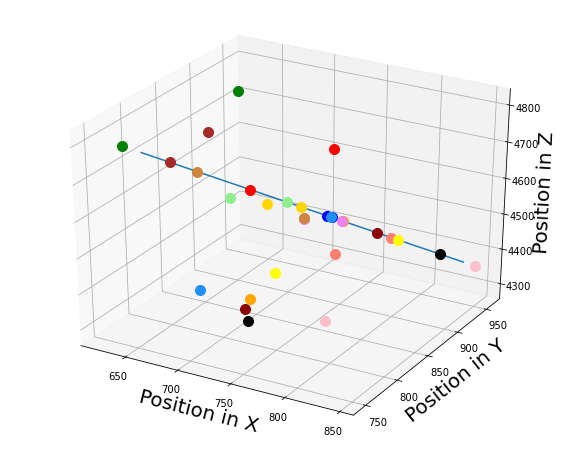

In [23]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111, projection = '3d')

# Plot the proximo-distal line
ax.plot([PS_proximal[0], PS_distal[0]], [PS_proximal[1],  PS_distal[1]], [PS_proximal[2],  PS_distal[2]]) 

# plot the original positions
colors = ['blue', 'orange', 'pink', 'red', 'lightgreen', 'brown', 'black', 'dodgerblue','green', 'salmon', 'darkred', 'violet', 'gold','yellow', 'peru','plum', 'lime', 'grey']
i = 0
for name, c_id in start_tracks.items():
    start_pos = lT.pos[c_id] * [0.406, 0.406, 2.031]
    ax.plot([start_pos[0]], [start_pos[1]], [start_pos[2]], color = colors[i], marker = 'o', markersize = 10)
    i += 1

 # plot the projected points on the line 
i = 0
for name, cell in start_PD_points.items():
    ax.plot([cell[0]], [cell[1]], [cell[2]], color = colors[i], marker = 'o', markersize = 10)
    i += 1

ax.set_xlabel('Position in X', size = 20)
ax.set_ylabel('Position in Y', size = 20)
ax.set_zlabel('Position in Z', size = 20)

In [24]:
# In fact, we are interested in calculating a Proximo-distal value, where is that point located in respect to the PD axis?
# For that we keep the second value of the function which gives us a value from 0 to 1.
# The result includes the percentage of the line length where the point is located.

for name, c_id in start_tracks.items():
    start_pos = lT.pos[c_id] * [0.406, 0.406, 2.031]
    intersect = intersect_point_line(start_pos, PS_proximal, PS_distal)

    print(name, intersect[1])

ec_9 0.4198603928089142
uc 0.3867514431476593
mixed_ET -0.039513446390628815
et 0.673406720161438
my2 0.5598652958869934
CM_mes 0.9134173393249512
ec_10 0.0764789804816246
my3 0.4233526587486267
ec3 1.0562756061553955
ec_8 0.2326750010251999
my4 0.2791026532649994
etaorta1 0.38954463601112366
ec_7 0.515747606754303
ec_et_mes 0.21097256243228912
et7 0.8340802788734436


Now that we saw how the function works, we collect all this data to plot a distribution

In [25]:
start_PD = {}  # We gather the info in a dictionary name of the track and percentage Proximo-distal axis

for name, c_id in start_tracks.items():
    start_pos = lT.pos[c_id] * [0.406, 0.406, 2.031]
    intersect = intersect_point_line(start_pos, line[0], line[1])
    
    start_PD[name] = intersect[1]

Now plot a kde and rugplot to show the distribution of points over the PD axis

In [26]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd

In [27]:
# rename the entries as et or not et depending on the name of the track
# for that create a new dictionary from iterating the start_PD one

start_PD_celltype = {}
start_PD_celltype['et'] = []
start_PD_celltype['not_et'] = []

for name, percentageAP in start_PD.items():
    if any([substring in name for substring in ['ec','et','uc']]):
        start_PD_celltype['et'].append(percentageAP)
    else:
        start_PD_celltype['not_et'].append(percentageAP)
    
                            
    

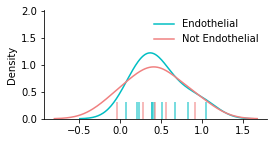

In [30]:
#plot one line at a time
mpl.rcParams['figure.figsize'] = 4,2 #make it a bit wider to make room for the labelsb
bandwidth = 1 # default parameter, smoothing of the kde (kernel density estimator) plot

# Endothelial
color = '#00bec3'
ax = sns.kdeplot(x = start_PD_celltype['et'],
                 color = color, bw_adjust = bandwidth, label = 'Endothelial')
ax = sns.rugplot(x = start_PD_celltype['et'],
                 linewidth = 1.5, alpha = 0.7, height = 0.15, color = color)

# Not Endothelial
color = 'lightcoral'
ax = sns.kdeplot(x = start_PD_celltype['not_et'],
                 color = color, bw_adjust = bandwidth, label = 'Not Endothelial')
ax = sns.rugplot(x = start_PD_celltype['not_et'],
                 linewidth = 1.5, alpha = 0.7, height = 0.15, color = color)

#ax.set_ylabel('density')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_ylim([0, 2.5])


ax.legend(loc='upper right', frameon = False)  # reverse both handles and labels

path = 'PD_distribution'

plt.savefig(os.path.join(out, path + '.svg'), dpi = 300)


In [27]:
## Save the results in a different name so later we can plot all the embryos together
KM1_start_PD_celltype = start_PD_celltype

## Repeat the same process with embryo MS2

In [33]:
## Path to data
tracking_file = 'S:\\LAB_MT\\RESULTADOS\\MiQuel\\Paper Endocardio\\data\\live_imaging\\tracking\\e361-mamut_v2_clean_with_PS_ref.xml'
## Path to save the figures
out = './figures_definitive'

# load .xml mamut tracking file with Lineage Tree libary
lT = lineageTree(tracking_file, MaMuT = True)

node_time = {}

for time, cid in lT.time_nodes.items():
    for item in cid:
        node_time[item] = time
        
start_ids = lT.time_nodes[0] #this list has some nodes that don't belong to a track. then they will give error when we try lT.track_name(id)
#We get rid of them by adding to a new clean list, only the start nodes that belong to a track


start_nodes = []
for cid in start_ids:
    try:
        lT.track_name[cid] 
        start_nodes.append(cid)
    except:
        pass
    
start_tracks = dict((lT.track_name[k], k) for k in start_nodes)

In [34]:
track_cycles = {} #this is the dictionary where we put all the cycles from all the progenitors, sorted by track name.
for name, c_id in start_tracks.items(): #this are all the initial ids, ids at time 0
    track_cycles[name] = [lT.get_cycle(c_id)]    # add a list of the initial cycles to the dictionary value. This will create a list of lists
    for cycle in track_cycles[name]:            # for every cycle performs this operation to find the following branches
        try:
            for suc in lT.successor[cycle[-1]]: # here it will find the cycle for each of the two successors that the last id of the cycle must contain
                track_cycles[name].append(lT.get_cycle(suc))
        except:
            pass  #there is gonna be a point where we do not have more progenitors, more branches. In that case an error will appear (most recent call last, traceback) it passes.
        
    #the peculiarity of this loop is that, as it runs, the list cycles increases, and thus it performs the operation over the 
    #new cycles that incorporate, but it will not repeat it again with the initial cycles.

for name, cycles in track_cycles.items(): #modify every value of the dictionary
    track_cycles[name] = track_cycles[name][::-1] #invert the value of every key. Which means invert the list of cycles of every track

In [35]:
tracks_cells = {} #definitive dictionary with all the complete cycles for first progenitor to last daughter
for name, c_cycles in track_cycles.items(): #iterating over the track names, so it does it for all tracks.
    tracks_cells[name] = [] #creat an empty list in the dictionary value, so it has somewhere to append on, in the first iteration.
    for daughter in c_cycles: #starts from the end to check one by one the cycles 
        try:
            lT.successor[daughter[-1]] #if this cell has no children then it gives Keyerror and jump to except
            break #when a cell has children we dont want to find their story
            
            
        except KeyError:
            find_story(daughter)

In [36]:
track_length = {}
for name, all_cells_track in track_cycles.items():
    track_length[name] = []
    for cell in all_cells_track:
        if (lT.time[cell[0]] != 0) & (lT.time[cell[-1]] != 82) : #  # discard firsts and lasts cells which cell cycle can be incomplete in the video
            track_length[name].append(len(cell)*20) # 17minutes time frame in case of MS2 video

track_length_MS2 = track_length

In [37]:
sigma = 1
name_Spos = {} #dictionary with the name of the track as the key, and the XYZ coordinates of all the cells in that track

for name, track in tracks_cells.items():
    name_Spos[name] = [] #create an empty list in value in order to have somewhere to append the XYZ arrays' list of each cell
    for cell in track:
        pos = np.array([lT.pos[c_id] for c_id in cell]) #global array of coordinates for that cell over time
        X_smooth = nd.filters.gaussian_filter1d(pos[:, 0], sigma=sigma, mode='nearest') * 1.183  #select all the arrays rows only column 0
        Y_smooth = nd.filters.gaussian_filter1d(pos[:, 1], sigma=sigma, mode='nearest') * 1.183  # transform units to microns
        Z_smooth = nd.filters.gaussian_filter1d(pos[:, 2], sigma=sigma, mode='nearest') * 5 
        Spos = np.column_stack((X_smooth, Y_smooth, Z_smooth))
        name_Spos[name].append(Spos)
        

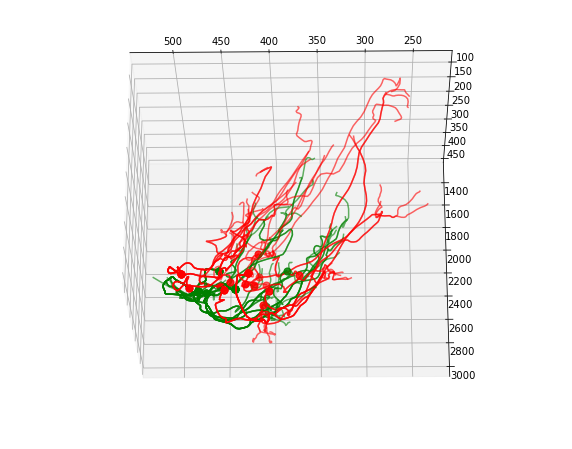

In [38]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111, projection = '3d')
cmap = ColorMap([11., 64.], 'plasma')
#colors = ['#8ffe09','r','#0033ff','#003311','#993333','#21c36f','#c46210','#ed3cca','#ffbf00','g','#000000','#8ffe09','r','#0033ff','#003311','#993333','#21c36f','#c46210','#ed3cca','#ffbf00','g','#000000']
a = -1 

for name, track in name_Spos.items():
    
    for cell in track:
        colorball = 'r' if 'm' in name else 'g'
        ax.plot(cell[:,0], cell[:,1], cell[:,2], color = colorball, alpha=.6) #X, Y, Z coordinates in the same array, in different columns
        ax.plot([cell[0,0]], [cell[0,1]], [cell[0,2]], colorball+'o', markersize = 7, alpha = .6) #This ones have to go bewteen brackets because the program has to calculate the lenght of the list. As it has only 1 element, we need to make a list so it has a lenght even so.
        #ax.set_xlabel('Position in X', size = 20)
        #ax.set_ylabel('Position in Y', size = 20)
        #ax.set_zlabel('Position in Z', size = 20)
    
# Hide axis ticks and labels
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)


# finally plot the reference primitive streak point
# for name, pos in ref_PS.items():
#     colorball = 'y' if 'prox' in name else 'k' 
#     ax.plot([pos[0]], [pos[1]], [pos[2]], colorball+'*', markersize = 19, label = name)
#     ax.legend()

    
ax.view_init(155, 89)

path = os.path.join(out, 'tracks_MS2' + '.svg')
plt.savefig(path, dpi = 300)


### Save two .points separate text files with the initial coordinates for Endothelial and non-endothelial progenitors
This way we can plot it along with the raw data on ImageJ 3d viewer, that way we do not depend on Imaris or Matlab code from 

In [83]:
et_points

[array([387.03387343, 288.90836017, 509.41079768]),
 array([399.28310502, 331.3691646 , 498.89158615]),
 array([423.62313846, 300.67203606, 486.14097287]),
 array([350.13222579, 254.27010156, 515.23177224]),
 array([347.3353521 , 324.51110647, 524.82600817]),
 array([324.88422345, 320.64750277, 467.85354851])]

In [87]:
et_names = ['13_endocardium',  'EC_1', 'extraembryonic_ET_and_mot_ET', 'ET_mes',  '8_endocardium', 'epiblast_gastrulating']
not_et_names = ['CM_MES_1_OK', 'mes_not_ET', 'CM_4_OK', '12_cranial mesoderm',  'not_Et_mes', 'CM_2_ExM_lost', '8_cardiac_mesoderm', 'mes_not:_et', '14_cardiac mesoderm', 'not_ET_mes', '14_cardiac_mesoderm']

et_points = np.array([lT.pos[start_tracks[name]] for name in et_names])
not_et_points = np.array([lT.pos[start_tracks[name]] for name in not_et_names])

# The coordinates are in pixels, in order to plot them on the raw data, we must transform them to microns
# Define the multiplication factors
factor_x_y = 1.183
factor_z = 5

# Multiply the columns by the respective factors
et_points[:, 0] *= factor_x_y  # Multiply the first column (X) by 1.183
et_points[:, 1] *= factor_x_y  # Multiply the second column (Y) by 1.183
et_points[:, 2] *= factor_z    # Multiply the third column (Z) by 5

# Now, et_points contains the updated values
# Do the same with not_et_points
not_et_points[:, 0] *= factor_x_y  # Multiply the first column (X) by 1.183
not_et_points[:, 1] *= factor_x_y  # Multiply the second column (Y) by 1.183
not_et_points[:, 2] *= factor_z    # Multiply the third column (Z) by 5

filename = "et.points"
points_array = et_points

# Open the file for writing
with open(filename, "w") as file:
    for i, point in enumerate(points_array):
        # Convert the point to a formatted string that imageJ 3D viewer can read
        point_str = f'"": {point.tolist()}' # Empty name so it doesnt bother on 3Dviewer

        # Write the formatted string to the file
        file.write(point_str)

        # Add a newline character to separate points
        if i < len(points_array) - 1:
            file.write("\n")

print(f"Points saved to {filename}")


Points saved to et.points


In [80]:
for name, track in name_Spos.items():
    
    for cell in track:
        colorball = 'r' if 'm' in name else 'g'
        ax.plot(cell[:,0], cell[:,1], cell[:,2], color = colorball, alpha=.6) #X, Y, Z coordinates in the same array, in different columns
        ax.plot([cell[0,0]], [cell[0,1]], [cell[0,2]], colorball+'o', markersize = 7, alpha = .6) #This ones have to go bewteen brackets because the program has to calculate the lenght of the list. As it has only 1 element, we need to make a list so it has a lenght even so.
        #ax.set_xlabel('Position in X', size = 20)
        #ax.set_ylabel('Position in Y', size = 20)
        #ax.set_zlabel('Position in Z', size = 20)

In [39]:
# We take the reference ids I clicked on the Primitive streak

ref_ids = []
for node_id, name in lT.node_name.items():
    if 'PS' in name:
        ref_ids.append(node_id)


# collect their names
ref_names = [lT.node_name[node_id] for node_id in ref_ids]

# and their coordinates, to plot later with the rest of the tracks
ref_pos = np.array([lT.pos[node_id] for node_id in ref_ids])

# normalize to microns 
ref_pos = ref_pos * [1.183, 1.183, 5]

#create a dictionary with their names and positions
ref_PS = dict(zip(ref_names, ref_pos))

# print to visualize
ref_PS


{'PS_distal': array([ 385.21653931,  370.80039338, 2640.51411452]),
 'PS_proximal': array([ 522.52663929,  389.78098764, 2332.94063791])}

In [40]:
PS_proximal, PS_distal = ref_pos[1], ref_pos[0]

In [41]:
start_PD_points = {}  # We gather the info in a dictionary name of the track and point projected to the Proximo-distal axis

for name, c_id in start_tracks.items():
    start_pos = lT.pos[c_id] * [1.183, 1.183, 5]
    intersect = intersect_point_line(start_pos, PS_proximal, PS_distal)
    
    start_PD_points[name] = np.array(intersect[0])

Text(0.5, 0, 'Position in Z')

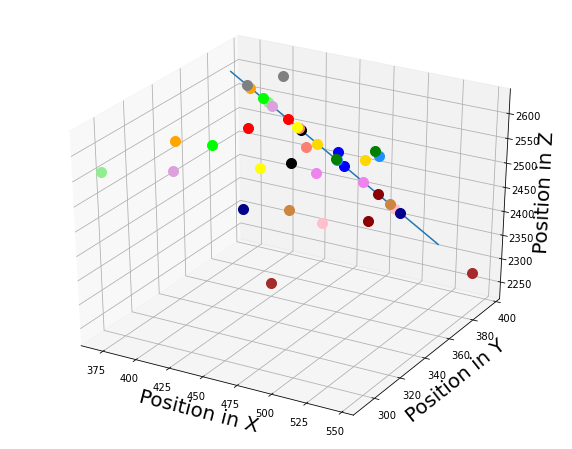

In [42]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111, projection = '3d')

# Plot the proximo-distal line
ax.plot([PS_proximal[0], PS_distal[0]], [PS_proximal[1],  PS_distal[1]], [PS_proximal[2],  PS_distal[2]]) 

# plot the original positions
colors = ['blue', 'orange', 'pink', 'red', 'lightgreen', 'brown', 'black', 'dodgerblue','green', 'salmon', 'darkred', 'violet', 'gold','yellow', 'peru','plum', 'lime', 'grey','darkblue','blue','red','green']
i = 0
for name, c_id in start_tracks.items():
    start_pos = lT.pos[c_id] * [1.183, 1.183, 5]
    ax.plot([start_pos[0]], [start_pos[1]], [start_pos[2]], color = colors[i], marker = 'o', markersize = 10)
    i += 1

 # plot the projected points on the line 
i = 0
for name, cell in start_PD_points.items():
    ax.plot([cell[0]], [cell[1]], [cell[2]], color = colors[i], marker = 'o', markersize = 10)
    i += 1

ax.set_xlabel('Position in X', size = 20)
ax.set_ylabel('Position in Y', size = 20)
ax.set_zlabel('Position in Z', size = 20)

In [43]:
start_PD = {}  # We gather the info in a dictionary name of the track and percentage Proximo-distal axis

for name, c_id in start_tracks.items():
    start_pos = lT.pos[c_id] * [1.183, 1.183, 5]
    intersect = intersect_point_line(start_pos, PS_proximal, PS_distal)
    
    start_PD[name] = intersect[1]
    
# rename the entries as et or not et depending on the name of the track
# for that create a new dictionary from iterating the start_PD one

start_PD_celltype = {}
start_PD_celltype['et'] = []
start_PD_celltype['not_et'] = []

for name, percentageAP in start_PD.items():
    if any([substring in name for substring in ['endocardium','ET']]):
        start_PD_celltype['et'].append(percentageAP)
    else:
        start_PD_celltype['not_et'].append(percentageAP)
    
                            

In [44]:
## Save the results in a different name so later we can plot all the embryos together
MS2_start_PD_celltype = start_PD_celltype

## Repeat the same process with embryo MS1


In [118]:
## Path to data
tracking_file = 'S:\\LAB_MT\\RESULTADOS\\MiQuel\\Paper Endocardio\\data\\live_imaging\\tracking\\e278-export-mamut.xml'
## Path to save the figures
out = './figures_definitive'

# load .xml mamut tracking file with Lineage Tree libary
lT = lineageTree(tracking_file, MaMuT = True)

node_time = {}

for time, cid in lT.time_nodes.items():
    for item in cid:
        node_time[item] = time
        
start_ids = lT.time_nodes[0] #this list has some nodes that don't belong to a track. then they will give error when we try lT.track_name(id)
#We get rid of them by adding to a new clean list, only the start nodes that belong to a track


start_nodes = []
for cid in start_ids:
    try:
        lT.track_name[cid] 
        start_nodes.append(cid)
    except:
        pass
    
start_tracks = dict((lT.track_name[k], k) for k in start_nodes)

In [119]:
filename = "e278_CMandET_points_coordinates.txt"

# Open the file for writing
with open(filename, "w") as file:
    for name, c_id in start_tracks.items():
        # Convert the point to a formatted string that imageJ 3D viewer can read
        coordinates = lT.pos[c_id]
        point_str = f'{name}: {coordinates.tolist()}' 

        # Write the formatted string to the file
        file.write(point_str)

        # Add a newline character to separate points
        file.write("\n")

print(f"Points saved to {filename}")

Points saved to e278_CMandET_points_coordinates.txt


In [41]:
track_cycles = {} #this is the dictionary where we put all the cycles from all the progenitors, sorted by track name.
for name, c_id in start_tracks.items(): #this are all the initial ids, ids at time 0
    track_cycles[name] = [lT.get_cycle(c_id)]    # add a list of the initial cycles to the dictionary value. This will create a list of lists
    for cycle in track_cycles[name]:            # for every cycle performs this operation to find the following branches
        try:
            for suc in lT.successor[cycle[-1]]: # here it will find the cycle for each of the two successors that the last id of the cycle must contain
                track_cycles[name].append(lT.get_cycle(suc))
        except:
            pass  #there is gonna be a point where we do not have more progenitors, more branches. In that case an error will appear (most recent call last, traceback) it passes.
        
    #the peculiarity of this loop is that, as it runs, the list cycles increases, and thus it performs the operation over the 
    #new cycles that incorporate, but it will not repeat it again with the initial cycles.

for name, cycles in track_cycles.items(): #modify every value of the dictionary
    track_cycles[name] = track_cycles[name][::-1] #invert the value of every key. Which means invert the list of cycles of every track

In [42]:
tracks_cells = {} #definitive dictionary with all the complete cycles for first progenitor to last daughter
for name, c_cycles in track_cycles.items(): #iterating over the track names, so it does it for all tracks.
    tracks_cells[name] = [] #creat an empty list in the dictionary value, so it has somewhere to append on, in the first iteration.
    for daughter in c_cycles: #starts from the end to check one by one the cycles 
        try:
            lT.successor[daughter[-1]] #if this cell has no children then it gives Keyerror and jump to except
            break #when a cell has children we dont want to find their story
            
            
        except KeyError:
            find_story(daughter)

In [43]:
track_length = {}
for name, all_cells_track in track_cycles.items():
    track_length[name] = []
    for cell in all_cells_track:
        if (lT.time[cell[0]] != 0) & (lT.time[cell[-1]] != 70) : # discard firsts and lasts cells which cell cycle can be incomplete in the video
            track_length[name].append(len(cell)*10) # 10minutes time frame in case of MS1 video

track_length_MS1 = track_length

In [44]:
sigma = 1
name_Spos = {} #dictionary with the name of the track as the key, and the XYZ coordinates of all the cells in that track

for name, track in tracks_cells.items():
    name_Spos[name] = [] #create an empty list in value in order to have somewhere to append the XYZ arrays' list of each cell
    for cell in track:
        pos = np.array([lT.pos[c_id] for c_id in cell]) #global array of coordinates for that cell over time
        X_smooth = nd.filters.gaussian_filter1d(pos[:, 0], sigma=sigma, mode='nearest') * 0.593  #select all the arrays rows only column 0
        Y_smooth = nd.filters.gaussian_filter1d(pos[:, 1], sigma=sigma, mode='nearest') * 0.593  # transform units to microns
        Z_smooth = nd.filters.gaussian_filter1d(pos[:, 2], sigma=sigma, mode='nearest') * 5 
        Spos = np.column_stack((X_smooth, Y_smooth, Z_smooth))
        name_Spos[name].append(Spos)

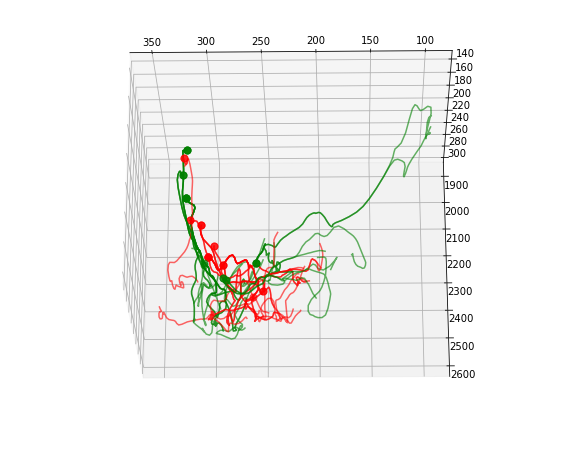

In [45]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111, projection = '3d')
cmap = ColorMap([11., 64.], 'plasma')
#colors = ['#8ffe09','r','#0033ff','#003311','#993333','#21c36f','#c46210','#ed3cca','#ffbf00','g','#000000','#8ffe09','r','#0033ff','#003311','#993333','#21c36f','#c46210','#ed3cca','#ffbf00','g','#000000']
a = -1 

for name, track in name_Spos.items():
    
    for cell in track:
        colorball = 'r' if 'CM' in name else 'g'
        ax.plot(cell[:,0], cell[:,1], cell[:,2], color = colorball, alpha=.6) #X, Y, Z coordinates in the same array, in different columns
        ax.plot([cell[0,0]], [cell[0,1]], [cell[0,2]], colorball+'o', markersize = 7, alpha = .6) #This ones have to go bewteen brackets because the program has to calculate the lenght of the list. As it has only 1 element, we need to make a list so it has a lenght even so.
        #ax.set_xlabel('Position in X', size = 20)
        #ax.set_ylabel('Position in Y', size = 20)
        #ax.set_zlabel('Position in Z', size = 20)
    
# Hide axis ticks and labels
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)


# finally plot the reference primitive streak point
# for name, pos in ref_PS.items():
#     colorball = 'y' if 'prox' in name else 'k' 
#     ax.plot([pos[0]], [pos[1]], [pos[2]], colorball+'*', markersize = 19, label = name)
#     ax.legend()

    
ax.view_init(155, 89)

path = os.path.join(out, 'tracks_embryo1_janelia' + '.svg')
plt.savefig(path, dpi = 300)

In [46]:
# We take the reference ids I clicked on the Primitive streak

ref_ids = []
for node_id, name in lT.node_name.items():
    if 'PS' in name:
        ref_ids.append(node_id)


# collect their names
ref_names = [lT.node_name[node_id] for node_id in ref_ids]

# and their coordinates, to plot later with the rest of the tracks
ref_pos = np.array([lT.pos[node_id] for node_id in ref_ids])

# normalize to microns 
ref_pos = ref_pos * [0.593, 0.593, 5]

#create a dictionary with their names and positions
ref_PS = dict(zip(ref_names, ref_pos))

# print to visualize
ref_PS

{'PS_distal': array([ 324.91645975,  293.13175999, 1753.81715723]),
 'PS_proximal': array([ 344.52035121,  221.80696341, 1753.81715723])}

In [47]:
PS_proximal, PS_distal = ref_pos[1], ref_pos[0]

In [48]:
start_PD_points = {}  # We gather the info in a dictionary name of the track and point projected to the Proximo-distal axis

for name, c_id in start_tracks.items():
    start_pos = lT.pos[c_id] * [0.593, 0.593, 5]
    intersect = intersect_point_line(start_pos, PS_proximal, PS_distal)
    
    start_PD_points[name] = np.array(intersect[0])

In [49]:
start_PD = {}  # We gather the info in a dictionary name of the track and percentage Proximo-distal axis

for name, c_id in start_tracks.items():
    start_pos = lT.pos[c_id] * [0.593, 0.593, 5]
    intersect = intersect_point_line(start_pos, PS_proximal, PS_distal)
    
    start_PD[name] = intersect[1]
    
# rename the entries as et or not et depending on the name of the track
# for that create a new dictionary from iterating the start_PD one

start_PD_celltype = {}
start_PD_celltype['et'] = []
start_PD_celltype['not_et'] = []

for name, percentageAP in start_PD.items():
    if any([substring in name for substring in ['EC']]):
        start_PD_celltype['et'].append(percentageAP)
    elif any([substring in name for substring in ['CM']]):
        start_PD_celltype['not_et'].append(percentageAP)
    

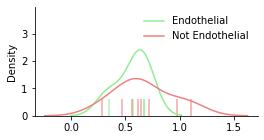

In [50]:
#plot one line at a time
mpl.rcParams['figure.figsize'] = 4,2 #make it a bit wider to make room for the labelsb
bandwidth = 1 # default parameter, smoothing of the kde (kernel density estimator) plot

# Endothelial
color = 'lightgreen'
ax = sns.kdeplot(x = start_PD_celltype['et'],
                 color = color, bw_adjust = bandwidth, label = 'Endothelial')
ax = sns.rugplot(x = start_PD_celltype['et'],
                 linewidth = 1.5, alpha = 0.7, height = 0.15, color = color)

# Not Endothelial
color = 'lightcoral'
ax = sns.kdeplot(x = start_PD_celltype['not_et'],
                 color = color, bw_adjust = bandwidth, label = 'Not Endothelial')
ax = sns.rugplot(x = start_PD_celltype['not_et'],
                 linewidth = 1.5, alpha = 0.7, height = 0.15, color = color)

#ax.set_ylabel('density')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_ylim([0, 2.5])


ax.legend(loc='upper right', frameon = False)  # reverse both handles and labels

path = 'PD_distribution_MS1'

plt.savefig(os.path.join(out, path + '.svg'), dpi = 300)


In [51]:
## Save the results in a different name so later we can plot all the embryos together
MS1_start_PD_celltype = start_PD_celltype

#### Plot all three together

In [52]:
# In order to plot the distribution of all embryos, we create a dictionary containing all data

KM1_MS2_MS1_start_PD_celltype = KM1_start_PD_celltype.copy() # Copy of KM1 to then append MS2

# Append values from embryo MS2
KM1_MS2_MS1_start_PD_celltype['et'] += MS2_start_PD_celltype['et']
KM1_MS2_MS1_start_PD_celltype['not_et'] += MS2_start_PD_celltype['not_et']

# Append values from embryo MS1
KM1_MS2_MS1_start_PD_celltype['et'] += MS1_start_PD_celltype['et']
KM1_MS2_MS1_start_PD_celltype['not_et'] += MS1_start_PD_celltype['not_et']

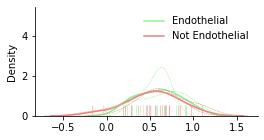

In [53]:
#plot one line at a time
mpl.rcParams['figure.figsize'] = 4,2 #make it a bit wider to make room for the labelsb
bandwidth = 1 # default parameter, smoothing of the kde (kernel density estimator) plot
rugwith = 0.5
rugh = 0.1
alpha = 0.5

# Plot data from all embryos in a kdeplot to summarize all embryos, with a wider line (linewidth = 1.5)

data = KM1_MS2_MS1_start_PD_celltype
# Endothelial
color = 'lightgreen'
ax = sns.kdeplot(x = data['et'],linewidth = 1.5,
                 color = color, bw_adjust = bandwidth, label = 'Endothelial')

# Not Endothelial
color = 'lightcoral'
ax = sns.kdeplot(x = data['not_et'],linewidth = 1.5,
                 color = color, bw_adjust = bandwidth, label = 'Not Endothelial')

# Now each embryo individually with a dashed and thinner line
data = KM1_start_PD_celltype
# Endothelial
color = 'lightgreen'
ax = sns.kdeplot(x = data['et'],linewidth = 0.5,  linestyle="--",
                 color = color, bw_adjust = bandwidth)
ax = sns.rugplot(x = data['et'],
                 linewidth = rugwith, alpha = alpha, height = rugh, color = color)

# Not Endothelial
color = 'lightcoral'
ax = sns.kdeplot(x = data['not_et'],linewidth = 0.5,  linestyle="--",
                 color = color, bw_adjust = bandwidth)
ax = sns.rugplot(x = data['not_et'],
                 linewidth = rugwith, alpha = alpha, height = rugh, color = color)


data = MS2_start_PD_celltype
# Endothelial
color = 'lightgreen'
ax = sns.kdeplot(x = data['et'],linewidth = 0.5, linestyle="--",
                 color = color, bw_adjust = bandwidth)
ax = sns.rugplot(x = data['et'],
                 linewidth = rugwith, alpha = alpha, height = rugh, color = color)

# Not Endothelial
color = 'lightcoral'
ax = sns.kdeplot(x = data['not_et'], linewidth = 0.5, linestyle="--",
                 color = color, bw_adjust = bandwidth)
ax = sns.rugplot(x = data['not_et'],
                 linewidth = rugwith, alpha = alpha, height = rugh, color = color)

data = MS1_start_PD_celltype
# Endothelial
color = 'lightgreen'
ax = sns.kdeplot(x = data['et'],linewidth = 0.5, linestyle="--",
                 color = color, bw_adjust = bandwidth)
ax = sns.rugplot(x = data['et'],
                 linewidth = rugwith, alpha = alpha, height = rugh, color = color)

# Not Endothelial
color = 'lightcoral'
ax = sns.kdeplot(x = data['not_et'], linewidth = 0.5, linestyle="--",
                 color = color, bw_adjust = bandwidth)
ax = sns.rugplot(x = data['not_et'],
                 linewidth = rugwith, alpha = alpha, height = rugh, color = color)

#ax.set_ylabel('density')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_ylim([0, 2.5])


ax.legend(loc='upper right', frameon = False)  # reverse both handles and labels

path = 'PD_distribution_MS2_MS1_KM1'

plt.savefig(os.path.join(out, path + '.svg'), dpi = 300)


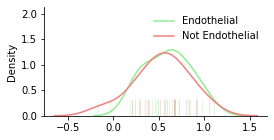

In [54]:
#plot one line at a time
mpl.rcParams['figure.figsize'] = 4,2 #make it a bit wider to make room for the labelsb
bandwidth = 1 # default parameter, smoothing of the kde (kernel density estimator) plot
rugwith = 0.5
rugh = 0.15
alpha = 0.5

# Plot data from all embryos in a kdeplot to summarize all embryos, with a wider line (linewidth = 1.5)

data = KM1_MS2_MS1_start_PD_celltype
# Endothelial
color = 'lightgreen'
ax = sns.kdeplot(x = data['et'],linewidth = 1.5,
                 color = color, bw_adjust = bandwidth, label = 'Endothelial')
ax = sns.rugplot(x = data['not_et'],
                 linewidth = rugwith, alpha = alpha, height = rugh, color = color)


# Not Endothelial
color = 'lightcoral'
ax = sns.kdeplot(x = data['not_et'],linewidth = 1.5,
                 color = color, bw_adjust = bandwidth, label = 'Not Endothelial')
ax = sns.rugplot(x = data['et'],
                 linewidth = rugwith, alpha = alpha, height = rugh, color = color)



# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_ylim([0, 2.5])


ax.legend(loc='upper right', frameon = False)  # reverse both handles and labels

path = 'PD_distribution_MS2_MS1_KM1'

plt.savefig(os.path.join(out, path + '.svg'), dpi = 300)


### Calculate the average division time

In [55]:
track_length

{'CM': [],
 'MES_SP': [220, 210],
 'EC1': [160, 250, 220, 220],
 'CM1': [],
 'CM9': [10, 370, 390],
 'EX_ET1': [490, 380],
 'CM3': [220, 220, 200, 180],
 'CM8': [90, 10, 30, 170, 10, 230],
 'CM5': [220, 40],
 'EC': [60],
 'CM2': [10, 170, 180],
 'EC3': [130, 360, 80, 260, 250],
 'CM4': [10],
 'EC2': [10, 150, 170, 220]}

In [56]:
# KM1 embryo

length_type = {}
length_type['cell_type'] = []
length_type['time_min'] = []

for name, tracks_length in track_length_KM1.items():
    if any([substring in name for substring in ['ec','et','uc']]):
        for track_length in tracks_length:
            length_type['cell_type'].append('Endothelial')
            length_type['time_min'].append(track_length)
    else:
        for track_length in tracks_length:
            length_type['cell_type'].append('Not Endothelial')
            length_type['time_min'].append(track_length)

            
track_length_KM1 = length_type



# MS2 embryo

length_type = {}
length_type['cell_type'] = []
length_type['time_min'] = []

for name, tracks_length in track_length_MS2.items():
    if any([substring in name for substring in ['endocardium','ET']]):
        for track_length in tracks_length:
            length_type['cell_type'].append('Endothelial')
            length_type['time_min'].append(track_length)
    else:
        for track_length in tracks_length:
            length_type['cell_type'].append('Not Endothelial')
            length_type['time_min'].append(track_length)

            
track_length_MS2 = length_type


# MS1 embryo

length_type = {}
length_type['cell_type'] = []
length_type['time_min'] = []

for name, tracks_length in track_length_MS1.items():
    if any([substring in name for substring in ['EC']]):
        for track_length in tracks_length:
            length_type['cell_type'].append('Endothelial')
            length_type['time_min'].append(track_length)
    else:
        for track_length in tracks_length:
            length_type['cell_type'].append('Not Endothelial')
            length_type['time_min'].append(track_length)

            
track_length_MS1 = length_type

In [66]:
# Create dataframes of each dictionary, adding a column to say which embryo it is
KM1_division = pd.DataFrame(track_length_KM1)
KM1_division['Embryo'] = 'KM1'

MS2_division = pd.DataFrame(track_length_MS2)
MS2_division['Embryo'] = 'MS2'

MS1_division = pd.DataFrame(track_length_MS1)
MS1_division['Embryo'] = 'MS1'


# Concatenate all three dataframes in one
cell_division = pd.concat([KM1_division, MS2_division, MS1_division])

In [67]:
# Filter out errors, cells at the end and cells at the beggining
cell_division = cell_division[(700 > cell_division['time_min']) & (cell_division['time_min'] > 300)]

# Save as an excel file
cell_division.to_excel(os.path.join(out, 'cell_division_live_imaging.xlsx'))

### Plot division time

# Plot/calculate straightness of the tracks
Straightness could be an emerging property of endocardial progenitors. In order to know where that emerging property arises and related with the membrane phenotype we can plot it and detect how and when it starts. For that we will compare the straightness of the endocardial progenitors over time and also compare it with the miocardial.
that is: total distance/displacement

disp = position at last time point/ position at first time point (norm 'modulo del vector')
<br> dist = Suma: position2-position1 (norm) + position 3-position 2 ...


First define functions to calculate displacement and distance between XYZ in a track.
That will allow to calculate moving windows easier. 

In [106]:
def track_displacement (cell, view_point, dt):
    '''This function calculates the displacement between point N1 and Nx in XYZ,
    by calculating the norm between the coordinates N1 and Nx)'''
    displacement = np.linalg.norm(lT.pos[cell[view_point-dt]] - lT.pos[cell[view_point+dt]])
    return displacement


def track_distance (cell, view_point, dt):
    '''This function calculates the total distance between point N1 and Nx in XYZ,
    by cumulative sum of the norms between the coordinates N1-N2, N2-N3 ... NX-1, Nx)'''
    
    total_distance = 0
    for spot in range(view_point - dt, view_point + dt - 1):
        # from starting timepoint in the moving window to last (minus 1) timepoint  
        # The ending timepoint doesnt have a following spot to calculate the norm
        
        disp = np.linalg.norm(lT.pos[cell[spot]] - lT.pos[cell[spot+1]])
        # Displacement between spot x and spot x+1
        total_distance += disp
        # cum_distance acumulates the displacement values to get a total traveled distance        
    
    return total_distance

Now loop over all the tracks and obtain a list of moving window values for straightness along time

In [283]:
# choose a window time for the moving window.
dt = 48 # 12 timepoints is 1 hour
t = dt

counter = 0

name_straightness = {}
# initialize a dictionary to save each track name with its moving time window straightness values in a list

for name, all_daughters in tracks_cells.items():
    # tracks_cells contain each bound progenitors, so data is duplicated in mother cells
    # track_cycles contain each track without divisions, progenitors are not bound to their successors
    # with a list of arrays containing spot ids for each of the daughters 
    
    for daughter in all_daughters:
        # this selects one of the daughters        
        straightness = []
        # initialize an empty list where we will save the straightness values for the moving window
        
        for view_point in range(t, len(daughter) - dt - 1):
            # we subtract 1 to get the final index number 
            # because len() gives the total length of the array, which is 1 more than the maximum index number

            straightness_window = track_displacement(daughter, view_point, dt) / track_distance(daughter, view_point, dt)
            # Calculate straightness for moving view_point
            
            straightness.append(straightness_window) 

            view_point +=1 
            # advance 1 viewpoint at the time
                        
        name_straightness[name + '_' + str(daughter[-1])] = straightness
        # for each cell in the track, save the straightness list, 
        # corresponding to all the straightness values, calculated for each window      


In [290]:
# choose a window time for the moving window.
dt = 48 # 12 timepoints is 1 hour
t = dt

name_straightness = {}
# initialize a dictionary to save each cell_id name with its moving time window straightness value

for name, all_daughters in tracks_cells.items():
    # tracks_cells contain each bound progenitors, so data is duplicated in mother cells
    # track_cycles contain each track without divisions, progenitors are not bound to their successors
    # with a list of arrays containing spot ids for each of the daughters 
    
    for daughter in all_daughters:
        # this selects one of the daughters        
        
        for view_point in range(t, len(daughter) - dt - 1):
            # we subtract 1 to get the final index number 
            # because len() gives the total length of the array, which is 1 more than the maximum index number

            straightness = track_displacement(daughter, view_point, dt) / track_distance(daughter, view_point, dt)
            # Calculate straightness for moving view_point
            

            view_point +=1 
            # advance 1 viewpoint at the time
                        
            name_straightness[daughter[view_point]] = straightness
            # for each cell_id in the track, save the straightness value, 
            # corresponding to all the straightness values, calculated for each window      


In [ ]:
lT.

In [295]:
lT.time[daughter[view_point]]

307

Plot results

In [284]:
# Convert to pandas so it is easier to plot with seaborn

df_straightness = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in name_straightness.items() ]))

df_straightness['time'] = df_straightness.index*5
df_straightness = df_straightness.melt(id_vars = ['time'], var_name = 'cell_id', value_name = 'straightness')

# replace

In [285]:
et_names = ['uc', 'et', 'ec']

def cell_type(row):
    if any(substring in row for substring in et_names):
        cell_name = 'endothelial'
    else:
        cell_name = 'non endothelial'
        
    return cell_name

In [286]:
df_straightness['cell_type'] = df_straightness['cell_id'].apply(cell_type)

In [288]:
df_straightness

,time,cell_id,straightness,cell_type
0,0,ec_53247,0.295356,endothelial
1,5,ec_53247,0.410796,endothelial
2,10,ec_53247,0.381555,endothelial
3,15,ec_53247,0.369401,endothelial
4,20,ec_53247,0.393017,endothelial
5,25,ec_53247,NaN,endothelial
6,30,ec_53247,NaN,endothelial
7,35,ec_53247,NaN,endothelial
8,40,ec_53247,NaN,endothelial
9,45,ec_53247,NaN,endothelial


<IPython.core.display.Javascript object>


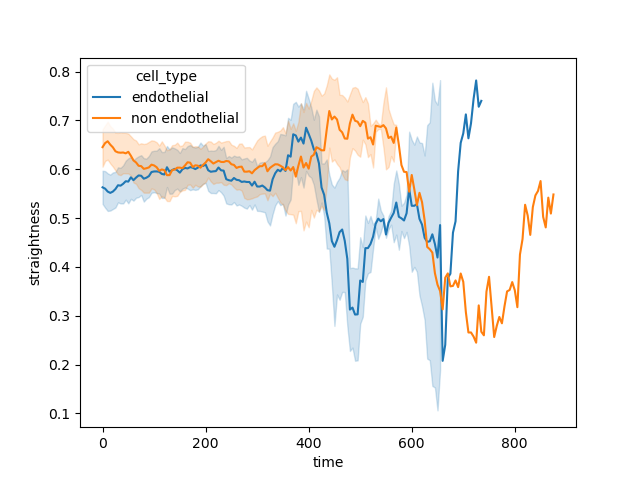

In [287]:
ax = sns.lineplot(data = df_straightness, x = 'time', y = 'straightness', hue = 'cell_type')

In [ ]:
sigma = 1
name_Spos = {} #dictionary with the name of the track as the key, and the XYZ coordinates of all the cells in that track

for name, track in tracks_cells.items():
    name_Spos[name] = [] #create an empty list in value in order to have somewhere to append the XYZ arrays' list of each cell
    for cell in track:
        pos = np.array([lT.pos[c_id] for c_id in cell]) #global array of coordinates for that cell over time
        X_smooth = nd.filters.gaussian_filter1d(pos[:, 0], sigma=sigma, mode='nearest') * 0.593  #select all the arrays rows only column 0
        Y_smooth = nd.filters.gaussian_filter1d(pos[:, 1], sigma=sigma, mode='nearest') * 0.593  # transform units to microns
        Z_smooth = nd.filters.gaussian_filter1d(pos[:, 2], sigma=sigma, mode='nearest') * 5 
        Spos = np.column_stack((X_smooth, Y_smooth, Z_smooth))
        name_Spos[name].append(Spos)

In [18]:
t = 0 #starting time
dt = 300 #len(tracks_cells['ec'][0]) #ending time #in this case preset as the last time point
name_disp = {} #contains all the displacement values for each cell in that track
for name, trackpos in name_Spos.items():
    name_disp[name] = []
    for cellpos in trackpos:
        pos_t1 = cellpos[t,:]
        pos_tfinal = cellpos[dt,:]
        disp = np.linalg.norm(pos_tfinal - pos_t1)
        name_disp[name].append(disp)

name_dist = {}
for name, trackpos in name_Spos.items():
    name_dist[name] = []
    for cellpos in trackpos:
        dist_cell = 0
        for i in range(t,dt+1):
            pos_t = cellpos[i,:]
            pos_at = cellpos[i+1,:]
            disp_at_t = np.linalg.norm(pos_at - pos_t)
            dist_cell += disp_at_t
        
        name_dist[name].append(dist_cell)
        

IndexError: index 300 is out of bounds for axis 0 with size 216

straightness = displacement / distance (total path)
1 means straight line from the start to the end
closer to 0 means completely undirected movement. 

In [ ]:
name_straightness = {}
for name, dist in name_disp.items():
    name_straightness[name] = np.array(name_disp[name])/np.array(name_dist[name])

In [ ]:
name_straightness

### Statistical difference between tracks?

First unify the tracks in cell type groups

In [ ]:
my = np.array([])
for name, data in name_straightness.items():
    if 'my' in name:
        my = np.append(my, data)

In [ ]:
et = np.array([])
for name, data in name_straightness.items():
    if 'e' or 'u' in name:
        et = np.append(et, data)

### Plot straightness counting all the track

In [ ]:
print ks_2samp(my, et), 'corazon', ' endoteliales'
# np.concatenate((name_straightness['ec'], name_straightness['ec2']), axis = 0)

In [ ]:
print ks_2samp(my, name_straightness['ec1']), 'myocardio', 'endocario'
# np.concatenate((name_straightness['ec'], name_straightness['ec2']), axis = 0)

In [ ]:
from scipy.stats import ks_2samp

#statistics
z, p = ks_2samp(my, et)
z1, p1 = ks_2samp(my, name_straightness['ec1'])

# We should usually use a two-tailed test because we have no a priori about one treatment being better than the other. We should therefore multiply p by two to obtain the p-value:
pvalue1 = p * 2
pvalue2 = p1 * 2 
print pvalue1

print ks_2samp(my, et), 'myocardio', ' endoteliales'
# np.concatenate((name_straightness['ec'], name_straightness['ec2']), axis = 0)

print ks_2samp(my, name_straightness['ec1']), 'myocardio', 'endocario'
# np.concatenate((name_straightness['ec'], name_straightness['ec2']), axis = 0)

s = stars(p)
print s

s1 = stars(p1)
print s1

print ks_2samp(my, et), 'myocardio', ' endoteliales'
# np.concatenate((name_straightness['ec'], name_straightness['ec2']), axis = 0)

print ks_2samp(my, name_straightness['ec1']), 'myocardio', 'endocario'
# np.concatenate((name_straightness['ec'], name_straightness['ec2']), axis = 0)



#plotting 


fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 2, 1)
ax.violinplot([my, et], showextrema=False)
ax.boxplot([my, et])
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['myocardio','endotelio'])
ax.set_ylim(0,1)
ax.set_title('strai')
ax.set_ylabel('straightness')

#annotation of the stars
y_max = np.max(np.concatenate((my, et)))
y_min = np.min(np.concatenate((my, name_straightness['ec1'])))

ax.annotate("", xy=(1, y_max), xycoords='data', 
           xytext=(2, y_max), textcoords='data',
           arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                           connectionstyle="bar,fraction=0.2"))
ax.text(1.5, y_max + abs(y_max - y_min)*0.1, stars(pvalue1),
       horizontalalignment='center',
       verticalalignment='center')


ax = fig.add_subplot(1, 2, 2)
ax.violinplot([my, name_straightness['ec1']], showextrema=False)
ax.boxplot([my, name_straightness['ec1']])
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['myocardio','endocardio'])
ax.set_ylim(0,1)
ax.set_title('strai')
ax.set_ylabel('straightness')


#annotation of the stars
y_max = np.max(np.concatenate((my, et)))
y_min = np.min(np.concatenate((my, name_straightness['ec1'])))

ax.annotate("", xy=(1, y_max), xycoords='data', 
           xytext=(2, y_max), textcoords='data',
           arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                           connectionstyle="bar,fraction=0.2"))
ax.text(1.5, y_max + abs(y_max - y_min)*0.1, stars(pvalue2),
       horizontalalignment='center',
       verticalalignment='center')
    
    


fig.tight_layout()

In [ ]:
a, b = ks_2samp(my, et)
b

In [ ]:
from scipy.stats import ks_2samp


#plot 1



fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 2, 1)
ax.violinplot([my, et], showextrema=False)
draw_plot([my, et], 'salmon', 'white')
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['myocardium','endothelium'])
ax.set_ylim(0,1)
ax.set_title('strai')
ax.set_ylabel('straightness')

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

ax.set_ylim(0,1)
ax.set_title('cell migration behavior').set_color('white')
ax.set_ylabel('straightness').set_color('white')
ax.set_xlabel('time (h)').set_color('white')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')


#making everything white for black bacgrounded presentation
violin_parts = ax.violinplot([my, et], showextrema=False)

for pc in violin_parts['bodies']:
    pc.set_facecolor('paleturquoise')
    pc.set_edgecolor('white')

    

#stats
z, pvalue = ks_2samp(my, et)    
s = stars(p)
print pvalue

y_max = np.max(np.concatenate((my, et)))
y_min = np.min(np.concatenate((my, name_straightness['ec1'])))

ax.annotate("", xy=(1, y_max), xycoords='data', 
           xytext=(2, y_max), textcoords='data',
           arrowprops=dict(arrowstyle="-", ec='white',
                           connectionstyle="bar,fraction=0.2"))
ax.text(1.5, y_max + abs(y_max - y_min)*0.1, stars(pvalue),  color = 'white',
       horizontalalignment='center',
       verticalalignment='center')
    
    
    
    
####################

ax = fig.add_subplot(1, 2, 2)
ax.violinplot([my, name_straightness['ec1']], showextrema=False)
draw_plot([my, name_straightness['ec1']], 'salmon', 'white')
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['myocardium','endocardium'])
ax.set_ylim(0,1)
ax.set_title('strai')
ax.set_ylabel('straightness')

'''
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

ax.set_ylim(0,1)
ax.set_title('cell migration behavior').set_color('white')
ax.set_ylabel('straightness').set_color('white')
ax.set_xlabel('time (h)').set_color('white')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
'''

violin_parts = ax.violinplot([my, name_straightness['ec1']], showextrema=False)

for pc in violin_parts['bodies']:
    pc.set_facecolor('paleturquoise')
    pc.set_edgecolor('white')
    
###stats plot 2 

z, pvalue = ks_2samp(my, name_straightness['ec1'])

s = stars(p)
print pvalue

y_max = np.max(np.concatenate((my, et)))
y_min = np.min(np.concatenate((my, name_straightness['ec1'])))

ax.annotate("", xy=(1, y_max), xycoords='data', 
           xytext=(2, y_max), textcoords='data',
           arrowprops=dict(arrowstyle="-", ec='white',
                           connectionstyle="bar,fraction=0.2"))
ax.text(1.5, y_max + abs(y_max - y_min)*0.1, stars(pvalue),  color = 'white',
       horizontalalignment='center',
       verticalalignment='center')
    
    
fig.tight_layout()
plt.savefig('test2.png',  format='png', dpi=1000, bbox_inches = 'tight', transparent = True)


In [ ]:
def draw_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       

example_data1 = [[1,2,0.8], [0.5,2,2], [3,2,1]]
example_data2 = [[5,3, 4], [6,4,3,8], [6,4,9]]

fig, ax = plt.subplots()
draw_plot(example_data1, 'red', 'tan')
draw_plot(example_data2, 'blue', 'cyan')
ax.set_ylim(0, 10)
plt.show()

In [ ]:
def stars(p):
    if p < 0.0001:
        return "****"
    elif (p < 0.001):
        return "***"
    elif (p < 0.01):
        return "**"
    elif (p < 0.05):
        return "*"
    else:
        return "-"

## The two-sample K–S test
Is one of the most useful and general nonparametric methods for comparing two samples, as it is sensitive to differences in both location and shape of the empirical cumulative distribution functions of the two samples.

The two-sample Kolmogorov-Smirnov test attempts to identify any differences in distribution of the populations the samples were drawn from. It is distribution-free. This means that (under the null) you can have the samples drawn from any continuous distribution, as long as it's the same one for both samples. It is weaker than the t-test at picking up a difference in the mean but it can pick up other kinds of difference that the t-test is blind to.

### Plot straightness by time intervals


Suprisingly straightness increases with time. During active alocation, the path is more straight. A greater displacement is achieved with fewer distance taken. This could be a more directed migration versus a mesodermal wing migration
<br> 
Maybe reducing the smoothing


Make function for plotting so you don't have to change the time manually

# Automatic plotting

## Straightness_plot 
If a function that plots the mean straightness at diferent time points of a track. The initial, ending time, and interval is specified by the user as t, tf and dt.

## Straightness_dict
Creates the dictionaries but does not plot the data gathered

In [ ]:
def straightness_dict (i, f, dt):
    #generates the dictionaries for displacement, distance and straightness for a time, interval

    timepoints = range(i, f, dt) #creates a list of timepoints to be plotted
    time_straightness = {} #dictionary to add the dictionaries corresponding for every time

    for t in range(1,len(timepoints)): # t will be an index to the list timepoints, which contains the selected times
        name_disp_t = {} #contains all the displacement values for each cell in that track
        for name, trackpos in name_Spos.items():
            name_disp_t[name] = []
            try:
                for cellpos in trackpos:
                    pos_t1 = cellpos[timepoints[t-1],:] #we want to take as starting position, the row 0 of the array (time 0)
                    pos_tfinal = cellpos[timepoints[t],:] #we want to take as finishing position, the row X of the array (time X) indicated by the list timepoints, index t
                    disp = np.linalg.norm(pos_tfinal - pos_t1) #calculate the norm, distance between one coordinate and the other
                    name_disp_t[name].append(disp) #append to the distances dictionary
            except:
                pass

        name_dist_t = {}
        for name, trackpos in name_Spos.items():
            name_dist_t[name] = []
            for cellpos in trackpos:
                try:
                    dist_cell = 0
                    for i in range(timepoints[t-1],timepoints[t]): #we need to calculate distance for every intermediate timepoint in the selected interval
                        pos_t = cellpos[i,:]  #i is a time of the range created above, and indicates as well the correct row in the array
                        pos_at = cellpos[i+1,:]
                        disp_at_t = np.linalg.norm(pos_at - pos_t)
                        dist_cell += disp_at_t #this value accumulates the small increments of distance registered every time point

                    name_dist_t[name].append(dist_cell)  #finally add this total distance to the dictionary    
                except:
                    pass

        name_straightness_t = {} #this dictionary is the division of both dictionaris above, to calculate the ratio disp/dist, which we call straightness
        for name, dist in name_disp_t.items():
            name_straightness_t[name] = np.array(name_disp_t[name])/np.array(name_dist_t[name])


        time_straightness[timepoints[t]] = name_straightness_t #incorporates the data for each time point
        #the zfill function is to give the key a consistent name '003' '060' '231' so the times follow a coherent order (optional)

    return time_straightness #so we can gather the dicitonary

In [ ]:
def straightness_plot(i,f,dt):
    timepoints = range(i, f, dt) #creates a list of timepoints to be plotted
    time_straightness = {}
#to get instructions from this code, refer to the one above
    for t in range(1,len(timepoints)):
        name_disp_t = {} #contains all the displacement values for each cell in that track
        for name, trackpos in name_Spos.items():
            name_disp_t[name] = []
            for cellpos in trackpos:
                try:
                    pos_t1 = cellpos[timepoints[t-1],:]
                    pos_tfinal = cellpos[timepoints[t],:]
                    disp = np.linalg.norm(pos_tfinal - pos_t1)
                    name_disp_t[name].append(disp)
                except:
                    pass

        name_dist_t = {}
        for name, trackpos in name_Spos.items():
            name_dist_t[name] = []
            for cellpos in trackpos:
                try:
                    dist_cell = 0
                    for i in range(timepoints[t-1],timepoints[t]):
                        pos_t = cellpos[i,:]
                        pos_at = cellpos[i+1,:]
                        disp_at_t = np.linalg.norm(pos_at - pos_t)
                        dist_cell += disp_at_t

                    name_dist_t[name].append(dist_cell)      
                except:
                    pass

        name_straightness_t = {}
        for name, dist in name_disp_t.items():
            name_straightness_t[name] = np.array(name_disp_t[name])/np.array(name_dist_t[name])


        time_straightness[timepoints[t]] = name_straightness_t

    fig = plt.figure(figsize=(8, 5)) #generates a frame where we can add the graphic elements
    ax = fig.add_subplot(1, 2, 1) #(rows, columns, position of this plot respective to rows columns indicated)
    ax.violinplot([time_straightness[time]['ec1'] for time in sorted(time_straightness.iterkeys())], showextrema=False) #every value in the time point is ploted. To select the correct time point we need to sort the iterator.
    ax.boxplot([time_straightness[time]['ec1'] for time in sorted(time_straightness.iterkeys())]) #same as above
    ax.set_xticks(range(len([time_straightness[x]['ec1'] for x in time_straightness])+1)) #number of x ticks must be the number of timepoints, thus number of entries for the for loop.
    ax.set_xticklabels([0] + sorted(time_straightness.keys(), key=int)) #starts by 0 and then the time points in the dictionary
    ax.set_ylim(0,1) #this straightness ratio is always defined from 0 to 1
    ax.set_title('endocardium progenitors') #costumize
    ax.set_ylabel('straightness')
    ax.set_xlabel('time portion')

    ax = fig.add_subplot(1, 2, 2)
    ax.violinplot([time_straightness[time]['my1'] for time in sorted(time_straightness.iterkeys())], showextrema=False)
    ax.boxplot([time_straightness[time]['my1'] for time in sorted(time_straightness.iterkeys())])
    ax.set_xticks(range(len([time_straightness[x]['my1'] for x in time_straightness])+1))
    ax.set_xticklabels([0] + sorted(time_straightness.keys(), key=int))
    ax.set_ylim(0,1)
    ax.set_title('cardiac progenitors')
    ax.set_ylabel('straightness')
    ax.set_xlabel('time portion')

    fig.tight_layout()

In [ ]:
straightness_plot(0,356,30)

In [ ]:
taca = np.array([3,2,4]+[3,2,6])

In [ ]:
taca

In [ ]:
time_straightness = straightness_dict(30,356,40)

In [ ]:
time_straightness_grouped = {} #this groups the straightness values by cell type, gathering data from different tracks of the same cell type

endothelium_ids = ['et','ec', 'uc']
myocardium_ids = ['my']

for time, track in time_straightness.items():
    time_straightness_grouped[time] = {}
    my = np.array([])
    et = np.array([])
    for cell, data in track.items():
        if any(c in cell for c in myocardium_ids):
            my = np.concatenate((my, data))
        if any(c in cell for c in endothelium_ids):
            et = np.concatenate((et, data))

    time_straightness_grouped[time]['et'] = et 
    time_straightness_grouped[time]['my'] = my
    
return time_straightness_grouped

In [ ]:
fig = plt.figure(figsize=(8, 5))
ax = plt.axes()

#first cell type 'my'

real_time = (np.array([time for time in sorted(time_straightness_grouped.iterkeys())])*5)/60 #Expressed in hours (every time point is 5 minutes)
straightness = [time_straightness_grouped[time]['my'] for time in sorted(time_straightness.iterkeys())]
average_straightness = [np.average(time_straightness_grouped[time]['my']) for time in sorted(time_straightness.iterkeys())]

plt.plot(real_time, straightness, color = 'skyblue', linewidth = 0.5)
plt.plot(real_time, average_straightness, color = 'darkblue', linestyle = '-', linewidth = 2, label = 'myocardium')
plt.legend()

straightness = [time_straightness_grouped[time]['et'] for time in sorted(time_straightness.iterkeys())]
average_straightness = [np.average(time_straightness_grouped[time]['et']) for time in sorted(time_straightness.iterkeys())]

plt.plot(real_time, straightness, color = 'peachpuff', linewidth = 0.5)
plt.plot(real_time, average_straightness, color = 'darkorange', linestyle = '-', linewidth = 2, label = 'endothelial')
plt.legend()




ax.set_ylim(0,1)
ax.set_title('cell migration behavior')
ax.set_ylabel('straightness')
ax.set_xlabel('time (h)')

plt.savefig('test2.png',  format='png', dpi=1000, bbox_inches = 'tight', transparent = True)

times = [keys for keys in sorted(time_straightness.iterkeys())]
print ks_2samp(time_straightness_grouped[times[-1]]['my'], time_straightness_grouped[times[-1]]['et']), 'myocardio', ' endoteliales' #critical timepoint
print ks_2samp(time_straightness_grouped[times[-2]]['my'], time_straightness_grouped[times[-2]]['et']), 'myocardio', ' endoteliales' #critical timepoint
print ks_2samp(time_straightness_grouped[times[-3]]['my'], time_straightness_grouped[times[-3]]['et']), 'myocardio', ' endoteliales' #critical timepoint
print ks_2samp(time_straightness_grouped[times[-4]]['my'], time_straightness_grouped[times[-4]]['et']), 'myocardio', ' endoteliales' #critical timepoint


In [ ]:
times = [keys for keys in sorted(time_straightness.iterkeys())]
times[-2]

In [ ]:
fig = plt.figure(figsize=(8, 5))
ax = plt.axes()

#first cell type 'my'

real_time = (np.array([time for time in sorted(time_straightness_grouped.iterkeys())])*5)/60 #Expressed in hours (every time point is 5 minutes)
straightness = [time_straightness_grouped[time]['my'] for time in sorted(time_straightness.iterkeys())]
average_straightness = [np.average(time_straightness_grouped[time]['my']) for time in sorted(time_straightness.iterkeys())]

plt.plot(real_time, straightness, color = 'skyblue', linewidth = 0.3)
plt.plot(real_time, average_straightness, color = 'lightskyblue' , linestyle = '-', linewidth = 2, label = 'myocardium')
plt.legend()

straightness = [time_straightness_grouped[time]['et'] for time in sorted(time_straightness.iterkeys())]
average_straightness = [np.average(time_straightness_grouped[time]['et']) for time in sorted(time_straightness.iterkeys())]

plt.plot(real_time, straightness, color = 'orange', linewidth = 0.3)
plt.plot(real_time, average_straightness, color = 'peachpuff', linestyle = '-', linewidth = 2, label = 'endothelial')
plt.legend()

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

ax.set_ylim(0,1)
ax.set_title('cell migration behavior').set_color('white')
ax.set_ylabel('straightness').set_color('white')
ax.set_xlabel('time (h)').set_color('white')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')


plt.savefig('test2.png',  format='png', dpi=1000, bbox_inches = 'tight', transparent = True)

times = [keys for keys in sorted(time_straightness.iterkeys())]
print ks_2samp(time_straightness_grouped[times[-1]]['my'], time_straightness_grouped[times[-1]]['et']), 'myocardio', ' endoteliales' #critical timepoint
print ks_2samp(time_straightness_grouped[times[-2]]['my'], time_straightness_grouped[times[-2]]['et']), 'myocardio', ' endoteliales' #critical timepoint
print ks_2samp(time_straightness_grouped[times[-3]]['my'], time_straightness_grouped[times[-3]]['et']), 'myocardio', ' endoteliales' #critical timepoint
print ks_2samp(time_straightness_grouped[times[-4]]['my'], time_straightness_grouped[times[-4]]['et']), 'myocardio', ' endoteliales' #critical timepoint


In [ ]:
times[-4]

In [ ]:
fig = plt.figure(figsize=(8, 5))
ax = plt.axes()

#fourth track type
real_time = (np.array([time for time in sorted(time_straightness.iterkeys())])*5)/60 #Expressed in hours (every time point is 5 minutes)
straightness = [time_straightness_grouped[time]['my'] for time in sorted(time_straightness.iterkeys())]
average_straightness = [np.average(time_straightness_grouped[time]['my']) for time in sorted(time_straightness.iterkeys())]

plt.plot(real_time, straightness, color = 'skyblue', linewidth = 0.3)
plt.plot(real_time, average_straightness, color = 'lightskyblue', linestyle = '-', linewidth = 2, label = 'myocardium')


#first track type
real_time = (np.array([time for time in sorted(time_straightness.iterkeys())])*5)/60 #Expressed in hours (every time point is 5 minutes)
straightness = [time_straightness[time]['ec1'] for time in sorted(time_straightness.iterkeys())]
average_straightness = [np.average(time_straightness[time]['ec1']) for time in sorted(time_straightness.iterkeys())]

plt.plot(real_time, straightness, color = 'orange', linewidth = 0.3)
plt.plot(real_time, average_straightness, color = 'peachpuff', linestyle = '-', linewidth = 2, label = 'endocardium')
plt.legend()

#second track type
real_time = (np.array([time for time in sorted(time_straightness.iterkeys())])*5)/60 #Expressed in hours (every time point is 5 minutes)
straightness = [time_straightness[time]['et'] for time in sorted(time_straightness.iterkeys())]
average_straightness = [np.average(time_straightness[time]['et']) for time in sorted(time_straightness.iterkeys())]

plt.plot(real_time, straightness, color = 'thistle', linewidth = 0.3)
plt.plot(real_time, average_straightness, color = 'thistle', linestyle = '-', linewidth = 0.000000000000000000001, label = 'endothelium')
plt.legend()

#third track type
real_time = (np.array([time for time in sorted(time_straightness.iterkeys())])*5)/60 #Expressed in hours (every time point is 5 minutes)
straightness = [time_straightness[time]['uc'] for time in sorted(time_straightness.iterkeys())]
average_straightness = [np.average(time_straightness[time]['uc']) for time in sorted(time_straightness.iterkeys())]

plt.plot(real_time, straightness, color = 'violet', linewidth = 0.3)
plt.plot(real_time, average_straightness, color = 'violet', linestyle = '-', linewidth = 0.000000000000000000001, label = 'umbilical cord')


plt.legend()


ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

ax.set_ylim(0,1)
ax.set_title('cell migration behavior').set_color('white')
ax.set_ylabel('straightness').set_color('white')
ax.set_xlabel('time (h)').set_color('white')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

plt.savefig('test3.png',  format='png', dpi = 1000, bbox_inches = 'tight', transparent = True)

ax.set_ylim(0,1)


print ks_2samp(time_straightness_grouped[280]['my'], time_straightness[280]['ec1']), 'myocardio', ' endoteliales' #critical timepoint



In [ ]:
fig = plt.figure(figsize=(8, 5))
ax = plt.axes()

#first cell type 'my'

real_time = (np.array([time for time in sorted(time_straightness_grouped.iterkeys())])*5)/60 #Expressed in hours (every time point is 5 minutes)
straightness = [time_straightness_grouped[time]['my'] for time in sorted(time_straightness.iterkeys())]
average_straightness = [np.average(time_straightness_grouped[time]['my']) for time in sorted(time_straightness.iterkeys())]

plt.plot(real_time, straightness, color = 'skyblue', linewidth = 0.3)
plt.plot(real_time, average_straightness, color = 'lightskyblue' , linestyle = '-', linewidth = 2, label = 'myocardium')
plt.legend()

straightness = [time_straightness_grouped[time]['et'] for time in sorted(time_straightness.iterkeys())]
average_straightness = [np.average(time_straightness_grouped[time]['et']) for time in sorted(time_straightness.iterkeys())]

plt.plot(real_time, straightness, color = 'orange', linewidth = 0.3)
plt.plot(real_time, average_straightness, color = 'peachpuff', linestyle = '-', linewidth = 2, label = 'endothelial')
plt.legend()

e

plt.savefig('test2.png',  format='png', dpi = 1000, bbox_inches = 'tight', transparent = True)

print ks_2samp(time_straightness_grouped[280]['my'], time_straightness_grouped[280]['et']), 'myocardio', ' endoteliales' #critical timepoint


I see a tendency that is, the straightness increasing suddely at some point (maybe this is the movement to the endoderm) and then it goes down again. But it depends on what time interval I use. Big intervals (40,50) show a tendency. but 30 or lower show no correlation. 12 time points = 1 hour. 

### smoothing the average

In [ ]:
fig = plt.figure(figsize=(8, 5))
ax = plt.axes()

real_time = (np.array([time for time in sorted(time_straightness.iterkeys())])*5)/60 #Expressed in hours (every time point is 5 minutes)
straightness = [time_straightness[time]['ec'] for time in sorted(time_straightness.iterkeys())]
a_smoothed = nd.filters.gaussian_filter1d([np.average(time_straightness[time]['ec']) for time in sorted(time_straightness.iterkeys())], sigma=0.6, mode='nearest')

plt.plot(real_time, straightness, color = 'silver', linewidth = 0.5)
plt.plot(real_time, a_smoothed, color = 'black', linestyle = '-', linewidth = 2)




ax.set_ylim(0,1)
ax.set_title('endocardium progenitors')
ax.set_ylabel('straightness')
ax.set_xlabel('time (h)')

In [ ]:
straightness_plot(0,300,40)

### Area explored by the cell

In [ ]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111, projection = '3d')



for cell_id in lT.time_nodes[1]:
    track = lT.get_cycle(cell_id)
    track_position_smooth = np.array([smooth_pos[c_id] for c_id in track])
    track_position = np.array([ids_positions[c_id] for c_id in track])
    
    X, Y, Z = track_position_smooth[:, 0], track_position_smooth[:, 1], track_position_smooth[:, 2]
    
    color = 'b' if 'end' in lT.track_name[cell_id] else 'r'
    colorf = 'dodgerblue' if 'end' in lT.track_name[cell_id] else 'lightcoral'
    ax.plot_trisurf(X,Y,Z, color = color)
    
ax.set_xlabel('Position in X', size = 20)
ax.set_ylabel('Position in Y', size = 20)
ax.set_zlabel('Position in Z', size = 20)
ax.set_title('Area explored')
    
ax.view_init(elev=13, azim=-83)
    
fig.tight_layout()

In [ ]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111, projection = '3d', facecolor = 'black')
cmap = ColorMap([11., 64.], 'plasma')

mycolors = ['plum', 'violet', 'coral','pink', 'salmon','plum', 'violet', 'pink','coral', 'salmon', 'plum', 'violet', 'coral','pink', 'salmon','plum', 'violet', 'pink','coral', 'salmon'] #redish colors
etcolors = ['paleturquoise', 'lightgreen', 'aqua', 'aquamarine', 'paleturquoise', 'lightgreen', 'aqua', 'aquamarine', 'paleturquoise', 'lightgreen', 'aqua', 'aquamarine', 'paleturquoise', 'lightgreen', 'aqua', 'aquamarine'] #greenish colors

#colors = ['#8ffe09','r','#0033ff','#003311','#993333','#21c36f','#c46210','#ed3cca','#ffbf00','g','#000000','#8ffe09','r','#0033ff','#003311','#993333','#21c36f','#c46210','#ed3cca','#ffbf00','g','#000000']

a = -1 

for name, track in name_Spos.items():
    if 'ec1' in name:
        typelabel = 'endothelium'
    elif 'my1' in name:
        typelabel = 'myocardium' 
    
    else:
        typelabel = ''
    
    colorball = 'lightcoral' if 'my' in name else 'lightskyblue'
    colors = mycolors if 'my' in name else etcolors
    
    for cell in track:
           
        X,Y,Z = cell[:,0], cell[:,1], cell[:,2]
        ax.plot_trisurf(X,Y,Z, color = colors[a], alpha = 0.3)
    
    ax.plot([cell[0,0]], [cell[0,1]], [cell[0,2]], colorball, marker ='o', markersize = 10, label = typelabel) #time point 1, big sphere
    #This ones have to go bewteen brackets because the program has to calculate the lenght of the list. As it has only 1 element, we need to make a list so it has a lenght even so.
    a = a-1 #counter to iterate through the random colors for the tracks
    
    
ax.set_xlabel('Position in X', size = 20, linespacing=5.2).set_color('white')
ax.set_ylabel('Position in Y', size = 20, linespacing=5.2).set_color('white')
ax.set_zlabel('Position in Z', size = 20, linespacing=5.2).set_color('white')

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.tick_params(axis='z', colors='white')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

ax.w_xaxis.set_pane_color((0, 0, 0, 0))
ax.w_yaxis.set_pane_color((0, 0, 0, 0))
ax.w_zaxis.set_pane_color((0, 0, 0, 0))

ax.legend()


ax.view_init(330, 45)

plt.savefig('test7.png',  format='png', dpi=1000, bbox_inches = 'tight', transparent = True)